### Imports

In order to use a package I have created, as well as other packages, we have to import them. If you haven't used a jupyter notebook before then you can press control enter to run the code blocks.

In [1]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

# The sim package is my package (in the sim folder)
from sim.utils import ScaledDist
from sim.model import elfi_sim
from sim.sum_stats import elfi_summary

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

### Run a simulation

In order to run a simulation, the simplest way (which is elfi compatible) is shown below. Note that the square brackets mean that those parameters are lists. The length of these lists should match the `batch_size` parameter, but `batch_size=1` should be fine in general. You may have to add an wildcats/output directory (it's on my gitignore).

In [2]:
%%time
pod = elfi_sim(
        bottleneck_strength_domestic=[3000],
        bottleneck_strength_wild=[30000],
        bottleneck_time_domestic=[3000],
        bottleneck_time_wild=[4000],
        captive_time=[20],
        div_time=[35000],
        mig_length_post_split=[1000],
        mig_length_wild=[20],
        mig_rate_captive=[0.01],
        mig_rate_post_split=[0.1],
        mig_rate_wild=[0.01],
        pop_size_captive=[1000],
        pop_size_domestic_1=[100],
        pop_size_domestic_2=[100],
        pop_size_wild_1=[500],
        pop_size_wild_2=[500],
        length=int(10e6),
        recombination_rate=1.8e-8,
        mutation_rate=6e-8,
        random_state=np.random.RandomState(3),
        batch_size=1
) 

print(f"pod has shape {pod.shape}")

INFO:root:Running command: slim -d captive_time=20 -d mig_length_wild=20 -d mig_rate_captive=0.01 -d mig_rate_wild=0.01 -d pop_size_captive=1000 -d pop_size_domestic_1=100 -d pop_size_wild_1=500 -d length=10000000 -d recombination_rate=1.8e-08  -d decap_trees_filename='"../output/decap_218175339.trees"' -s 40 slim_model.slim


pod has shape (1, 1)
Wall time: 1.53 s


### Simulation results format

The output is a 1 by 1 numpy matrix. Axis 0 corresponds to the batch_size (rows), Axis 1 corresponds to simulation outputs (which in our use case is always of shape 1).

In [3]:
pod = pod[0, 0]  # Get the result out the array

`pod` is a `GenotypeData` object, which I have defined in model.py. The attributes of the class have things you need for summary statistic calculation. For example, `pod.genotypes["domestic"]` would give you an array of the domestic genotypes. `pod.positions` gives a 1d array of the mutation positions.

In [4]:
pod.genotypes["all_pops"].shape

(47134, 45, 2)

Genotypes are given as 3 dimensional, where axis 0 is variants, axis 1 is individuals and axis 2 is ploidy.

### Calculating summary statistics

All the summary statistics can be calculated with:

In [7]:
summary_stats = elfi_summary(pod)
summary_stats.shape

(1, 102)

Again this is two dimensional, in which axis 0 is of size batch_size, and axis 1 is the number of summary statistics. You can have a look through sum_stats.py if you want to calculate specific summary statistics, for example to do a PCA:

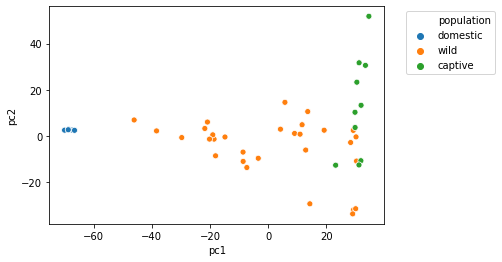

In [21]:
from sim.sum_stats import pca
pod.allelify()  # convert from numpy to scikit allel equivilents
pca_data = pca(pod.genotypes["all_pops"].to_n_alt(), pod.subpops)  # to_n_alt converts to 012 format
sns.scatterplot(pca_data["pc1"], pca_data["pc2"], hue=pca_data["population"])
plt.legend(bbox_to_anchor=(1.05, 1))

If you wish to add more summary statistics, I would suggest adding it as a function in sum_stats.py, which is then called in elfi_summary.

# Using elfi

### Priors

In elfi, SMC (and bolfi too if you use that), kicks up a fuss if parameters are badly scaled. To overcome this priors are defined using a class ScaledDist (from sim.utils.py).

In [33]:
from sim.utils import ScaledDist
fake_prior = ScaledDist(sampling=scipy.stats.lognorm(s=0.4, loc=0, scale=1),  # elfi will sample and infer from this distribution
                        target=scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.7)))  # elfi will scale up to this distribution in the simulator

The first distribution doesn't really matter, apart from it should be a standardish scale, and it's shape should match the target distribution so it can be scaled up. The second distribution is our actual prior. To ensure that scaling works as expected, you can plot the target distribution against a scaled set of samples from the sampling distribution:

[]

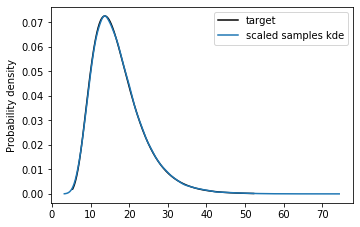

In [36]:
fake_prior.plot(show_scaled_kde=True)

I have defined my priors in priors.py. Running that script will produce a serialised prior dictionary using pickle. You might have to add the directory plots/priors (it's on my gitignore).

In [ ]:
exec(open('priors.py').read())  # Run priors.py

After running priors.py you should be able to read the prior back in with:

In [47]:
with open ("../output/priors.pkl", "rb") as f:
    priors = pickle.load(f)

[]

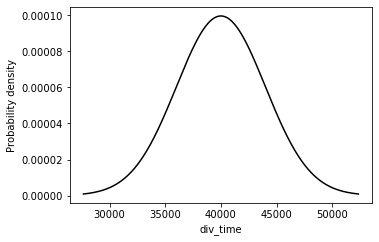

In [48]:
priors["div_time"].plot(x_lab="div_time")